# Sanity check on impact of sampling on the pulse shape

In [32]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib import colors, ticker
import itertools

!pip install ../h5flow
from h5flow.data import dereference
from proto_nd_flow.util.lut import LUT

Processing /global/u1/j/jvmead/dune/h5flow
  Preparing metadata (setup.py) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31643 sha256=9ab90fcf146cc0f0e42cf593afec2a9fcbec1433f26d1fbc62a8bd6f2f5785ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-mfep1ynd/wheels/0c/cb/86/6b657de7e9cca14c751cd866f4b2a2bfe75dd32620aa8569ce
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [33]:
# load csv generated in lrs_sanity_check from yaml file proto_nd_flow
channel_status = pd.read_csv('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_status/channel_status.csv', header=None).to_numpy()
print('Channel Status Shape:', np.shape(channel_status))

# load calibration csv as df
path = '/global/homes/j/jvmead/dune/lrs_sanity_check/calibration/data_calib.csv'
calib = pd.read_csv(path, header=None).to_numpy()
print(calib.shape)

fname = '/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july10_2024/nominal_hv/packet-0050018-2024_07_10_12_56_35_CDT.FLOW.hdf5'
f = h5py.File(fname)

Channel Status Shape: (8, 64)
(8, 64)


In [34]:
max_events = 1000
events = np.linspace(0,max_events,max_events+1,dtype=int)

light_wvfms = f['light/wvfm/data/']['samples'][events]/4.0

sipm_hits = f['light/sipm_hits/data']

n_samples = light_wvfms.shape[-1]
bin_width_ns = 16.0  # ns
time_bins = np.arange(0, n_samples, 1)*bin_width_ns

In [35]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/wvfm_noise_filter.py#L97-L123
def min_range_baseline(array, segment_size=25, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

In [36]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/hit_finder.py#L189-L231
from scipy.ndimage import uniform_filter1d

def peak_finder(#self,
                wvfm, noise,
                n_noise_factor = 5,
                n_bins_rolled = 5,
                n_sqrt_rt_factor = 3,
                pe_weight = 0.12,
                use_rising_edge=False,
                use_local_maxima=True):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])
    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)
    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]
    if use_rising_edge:
        return first_bins_over
    # Peak finding
    elif use_local_maxima:
        # check 5 bins after first_bins_over and add argmax
        peak_bins = np.zeros_like(wvfm, dtype=bool)
        first_bins_indices = np.where(first_bins_over)
        for idx in zip(*first_bins_indices):
            start_idx = idx[-1]
            end_idx = min(start_idx + 5, wvfm.shape[-1])
            peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
            peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    else:
        # Derivative-based peak detection
        wvfm_d1 = np.gradient(wvfm, axis=-1)
        wvfm_d2 = np.gradient(wvfm_d1, axis=-1)
        peak_bins = (wvfm > dynamic_threshold) & (wvfm > height) & \
            (wvfm_d1 < 0) & (wvfm_d2 < 0)
        # Keep only the first peak in consecutive runs
        peak_bins[..., 1:] &= ~peak_bins[..., :-1]

    return peak_bins

In [37]:
baselines, rms = min_range_baseline(light_wvfms)
light_wvfms_baselined = light_wvfms - baselines[:, :, :, np.newaxis]
cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
rms_calib = rms * calib[np.newaxis, :, :]
sipm_hits = peak_finder(wvfm=cwvfms, noise=rms_calib, n_noise_factor=5,
                        n_bins_rolled=5, n_sqrt_rt_factor=5, pe_weight=1.0)

Summing channels!

In [38]:
# these are generated in lrs_sanity_check/channel_sum_masks/ from the yaml file in proto_nd_flow

# import channel masks from npy files
ttype_sum = np.load('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_sum_masks/data_TrapType.npy')
print(ttype_sum.shape)

# example: for ttype 10, print channel indices (det_index, channel_index) and flattened indices
ttype = 10
indices = np.argwhere(ttype_sum[ttype])
print(f"TrapType {ttype}:")
for idx in indices:
    print(f"ADC {idx[0]} Channel {idx[1]}")

(16, 8, 64)
TrapType 10:
ADC 4 Channel 4
ADC 4 Channel 5
ADC 4 Channel 6
ADC 4 Channel 7
ADC 4 Channel 8
ADC 4 Channel 9
ADC 4 Channel 10
ADC 4 Channel 11
ADC 4 Channel 12
ADC 4 Channel 13
ADC 4 Channel 14
ADC 4 Channel 15
ADC 4 Channel 20
ADC 4 Channel 21
ADC 4 Channel 22
ADC 4 Channel 23
ADC 4 Channel 24
ADC 4 Channel 25
ADC 4 Channel 26
ADC 4 Channel 27
ADC 4 Channel 28
ADC 4 Channel 29
ADC 4 Channel 30
ADC 4 Channel 31


In [39]:
# sum the channels wvfms and rms by the DET masks
ttype_wvfms = np.zeros((light_wvfms.shape[0], ttype_sum.shape[0], light_wvfms.shape[3]))
ttype_rms = np.zeros((light_wvfms.shape[0], ttype_sum.shape[0]))
for i in range(ttype_sum.shape[0]):
    mask = ttype_sum[i] != 0
    ttype_wvfms[:, i, :] = np.sum(cwvfms[:, mask, :], axis=1)
    ttype_rms[:, i] = np.sqrt(np.sum(rms_calib[:, mask]**2, axis=1))
print(ttype_wvfms.shape)
print(ttype_rms.shape)

ttype_hits = peak_finder(wvfm=ttype_wvfms, noise=ttype_rms)
print(ttype_hits.shape)

(1001, 16, 1000)
(1001, 16)
(1001, 16, 1000)


In [40]:
# isolate [events,ttype] with 1 hit
events_with_hits = []
events_with_no_clipping = []
for evt in range(ttype_hits.shape[0]):
    for ttype in range(ttype_hits.shape[1]):
        n_hits = int(np.sum(ttype_hits[evt, ttype]))  # sum over samples
        if n_hits <= 0:
            continue
        # get (det, channel) index pairs for this ttype (shape: (N,2))
        indices = np.argwhere(ttype_sum[ttype])
        if indices.size == 0:
            # no channels for this ttype, skip
            continue
        # check for ADC saturation/clipping before accepting (guard against empty slice)
        max_val = light_wvfms[evt, indices[:, 0], indices[:, 1], :].max()
        if max_val > 8190:
            # skip clipped signals
            continue
        # record this event and ttype (only once per non-clipped hit)
        events_with_hits.append(evt)
        events_with_no_clipping.append((evt, ttype))

print(f'Found {len(events_with_no_clipping)} events and TType sum wvfms with hits')
print(f'Found {len(events_with_no_clipping)} events with no clipping in channels summed')

Found 2151 events and TType sum wvfms with hits
Found 2151 events with no clipping in channels summed


In [41]:
# get wvfms with 1 hit and no clipping and make a dataframe of the wvfm/data samples
hit_wvfms = []
for evt, ttype in events_with_no_clipping:
    n_hits = int(np.sum(ttype_hits[evt, ttype]))
    if n_hits == 1:
        hit_wvfms.append(ttype_wvfms[evt, ttype, :])
hit_wvfms = np.array(hit_wvfms)
print('Hit wvfms shape:', hit_wvfms.shape)

Hit wvfms shape: (855, 1000)


In [42]:
# make copies of the wvfms with downsampling applied, factor of 2, 4, and 8
#downsampled_wvfms_2 = hit_wvfms[:, ::2]
#downsampled_wvfms_4 = hit_wvfms[:, ::4]
#downsampled_wvfms_8 = hit_wvfms[:, ::8]
#downsampled_wvfns_16 = hit_wvfms[:, ::16]
# instead of simple slicing, do averaging to downsample
def downsample_average(wvfms, factor):
    n_samples = wvfms.shape[1]
    n_downsampled = n_samples // factor
    downsampled = np.zeros((wvfms.shape[0], n_downsampled))
    for i in range(n_downsampled):
        downsampled[:, i] = np.mean(wvfms[:, i*factor:(i+1)*factor], axis=1)
    return downsampled
downsampled_wvfms_2 = downsample_average(hit_wvfms, 2)
downsampled_wvfms_4 = downsample_average(hit_wvfms, 4)
downsampled_wvfms_8 = downsample_average(hit_wvfms, 8)
downsampled_wvfns_16 = downsample_average(hit_wvfms, 16)
print('Downsampled by 2 shape:', downsampled_wvfms_2.shape)
print('Downsampled by 4 shape:', downsampled_wvfms_4.shape)
print('Downsampled by 8 shape:', downsampled_wvfms_8.shape)
print('Downsampled by 16 shape:', downsampled_wvfns_16.shape)
# bin widths
bin_width_2 = bin_width_ns * 2
bin_width_4 = bin_width_ns * 4
bin_width_8 = bin_width_ns * 8
bin_width_16 = bin_width_ns * 16

Downsampled by 2 shape: (855, 500)
Downsampled by 4 shape: (855, 250)
Downsampled by 8 shape: (855, 125)
Downsampled by 16 shape: (855, 62)


In [43]:
# now make dataframes for each sample rate of the signal integral and the time of the peak of the hit
def make_hit_dataframe(wvfms, bin_width_ns):
    integrals = np.sum(wvfms, axis=1) * bin_width_ns  # sum over samples
    height = np.max(wvfms, axis=1)
    peak_times = []
    for wvfm in wvfms:
        peak_idx = np.argmax(wvfm)
        peak_time = peak_idx * bin_width_ns
        peak_times.append(peak_time)
    peak_times = np.array(peak_times)
    df = pd.DataFrame({
        'integral': integrals,
        'height': height,
        'peak_time': peak_times
    })
    return df

hit_df_original = make_hit_dataframe(hit_wvfms, bin_width_ns)
hit_df_downsampled_2 = make_hit_dataframe(downsampled_wvfms_2, bin_width_2)
hit_df_downsampled_4 = make_hit_dataframe(downsampled_wvfms_4, bin_width_4)
hit_df_downsampled_8 = make_hit_dataframe(downsampled_wvfms_8, bin_width_8)
hit_df_downsampled_16 = make_hit_dataframe(downsampled_wvfns_16, bin_width_16)

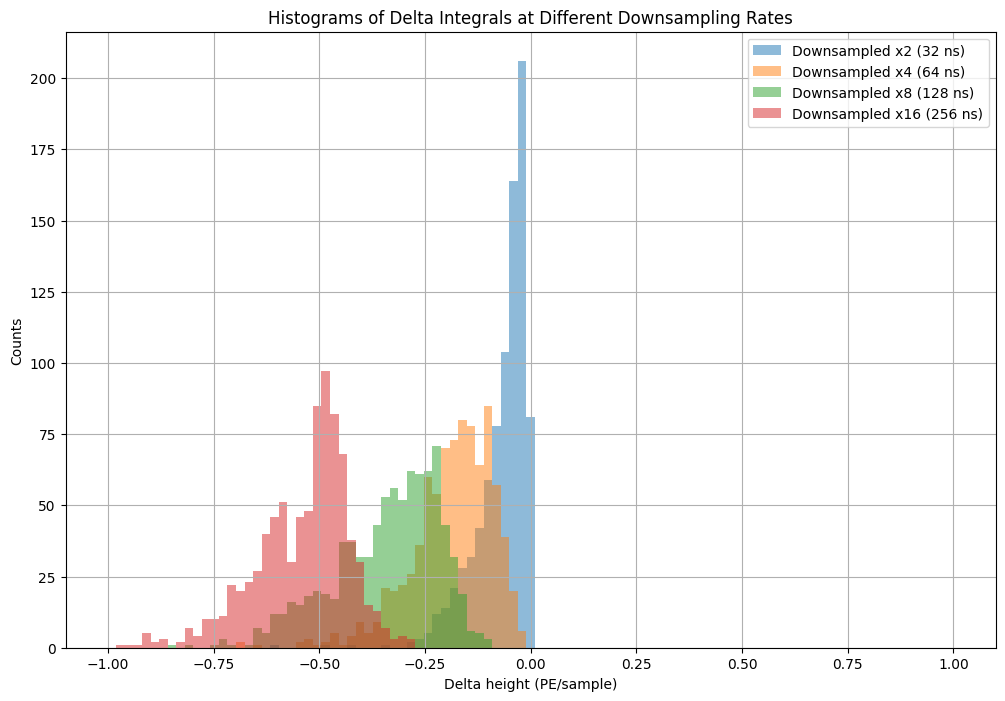

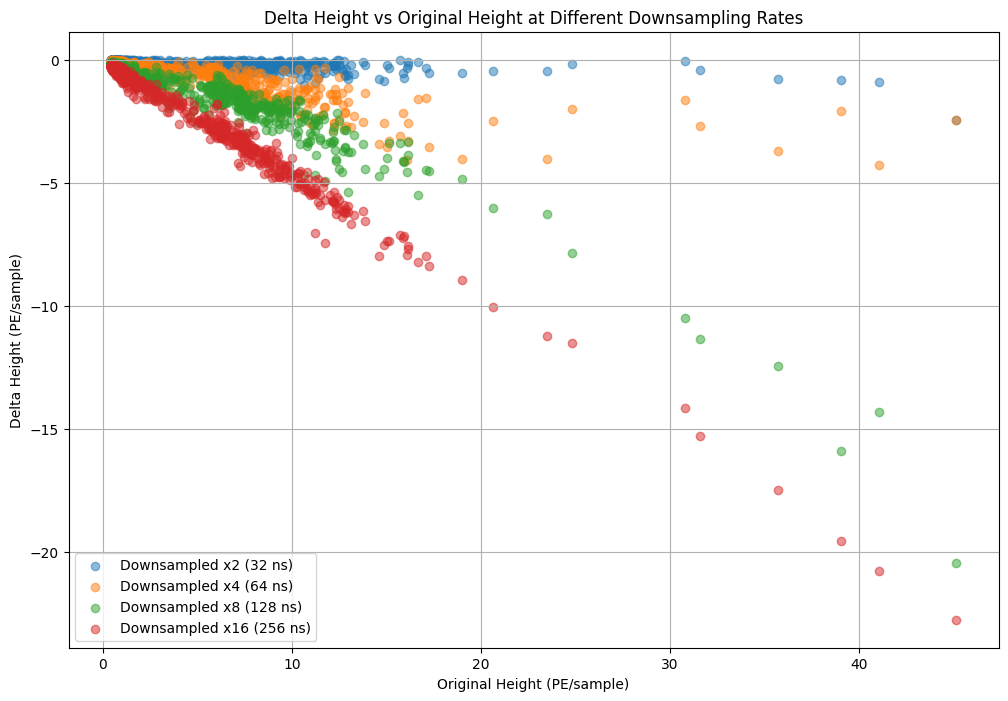

In [44]:
# plot the delta in integrals as a function of downsampling
delta_integral_2 = (hit_df_downsampled_2['height'] - hit_df_original['height'])/hit_df_original['height']
delta_integral_4 = (hit_df_downsampled_4['height'] - hit_df_original['height'])/hit_df_original['height']
delta_integral_8 = (hit_df_downsampled_8['height'] - hit_df_original['height'])/hit_df_original['height']
delta_integral_16 = (hit_df_downsampled_16['height'] - hit_df_original['height'])/hit_df_original['height']
plt.figure(figsize=(12, 8))
bins = np.linspace(-1, 1, 100)
plt.hist(delta_integral_2, bins=bins, alpha=0.5, label='Downsampled x2 (32 ns)')
plt.hist(delta_integral_4, bins=bins, alpha=0.5, label='Downsampled x4 (64 ns)')
plt.hist(delta_integral_8, bins=bins, alpha=0.5, label='Downsampled x8 (128 ns)')
plt.hist(delta_integral_16, bins=bins, alpha=0.5, label='Downsampled x16 (256 ns)')
plt.xlabel('Delta height (PE/sample)')
plt.ylabel('Counts')
plt.title('Histograms of Delta Integrals at Different Downsampling Rates')
plt.legend()
plt.grid()
plt.show()

# plot delta height as a function of original height
delta_height_2 = (hit_df_downsampled_2['height'] - hit_df_original['height'])
delta_height_4 = (hit_df_downsampled_4['height'] - hit_df_original['height'])
delta_height_8 = (hit_df_downsampled_8['height'] - hit_df_original['height'])
delta_height_16 = (hit_df_downsampled_16['height'] - hit_df_original['height'])
plt.figure(figsize=(12, 8))
plt.scatter(hit_df_original['height'], delta_height_2, alpha=0.5, label='Downsampled x2 (32 ns)')
plt.scatter(hit_df_original['height'], delta_height_4, alpha=0.5, label='Downsampled x4 (64 ns)')
plt.scatter(hit_df_original['height'], delta_height_8, alpha=0.5, label='Downsampled x8 (128 ns)')
plt.scatter(hit_df_original['height'], delta_height_16, alpha=0.5, label='Downsampled x16 (256 ns)')
plt.xlabel('Original Height (PE/sample)')
plt.ylabel('Delta Height (PE/sample)')
plt.title('Delta Height vs Original Height at Different Downsampling Rates')
plt.legend()
plt.grid()
plt.show()


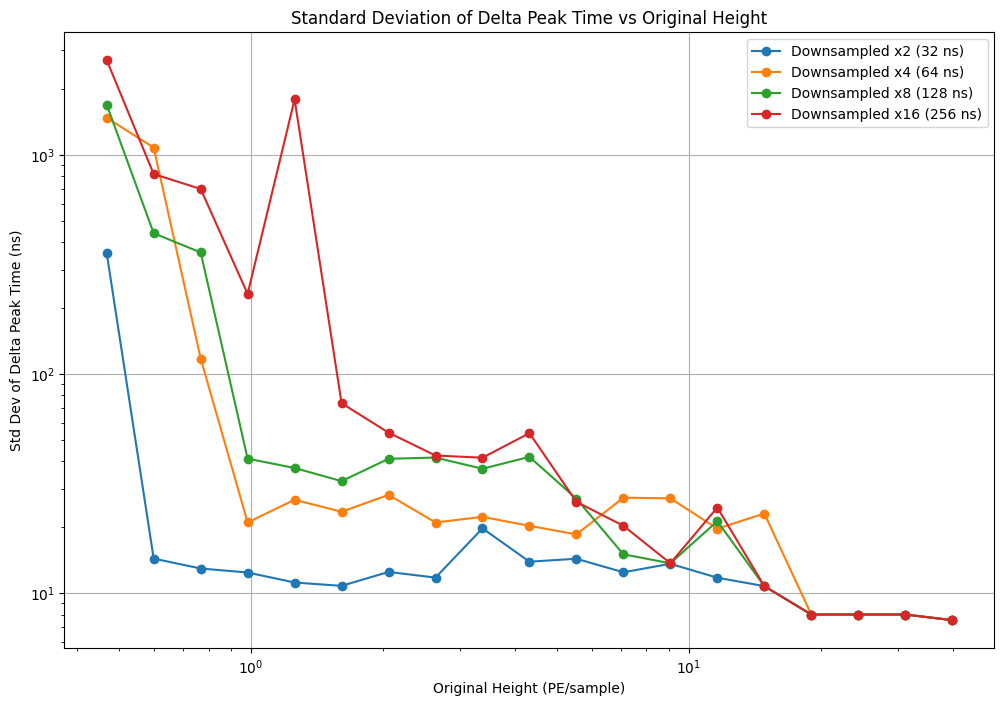

In [45]:
# plot scatter of delta time vs integral
delta_peak_2 = hit_df_downsampled_2['peak_time'] - hit_df_original['peak_time']
delta_peak_4 = hit_df_downsampled_4['peak_time'] - hit_df_original['peak_time']
delta_peak_8 = hit_df_downsampled_8['peak_time'] - hit_df_original['peak_time']
delta_peak_16 = hit_df_downsampled_16['peak_time'] - hit_df_original['peak_time']

# calculate standard deviation of delta_peak in bins of original height
bins = np.logspace(np.log10(hit_df_original['height'].min()),
           np.log10(hit_df_original['height'].max()), 20)
bin_centers = np.sqrt(bins[:-1] * bins[1:])

def calc_binned_std(heights, deltas, bins):
  bin_indices = np.digitize(heights, bins)
  stds = []
  for i in range(1, len(bins)):
    mask = bin_indices == i
    if np.sum(mask) > 0:
      stds.append(np.std(deltas[mask]))
    else:
      stds.append(np.nan)
  return np.array(stds)

std_2 = calc_binned_std(hit_df_original['height'], delta_peak_2, bins)
std_4 = calc_binned_std(hit_df_original['height'], delta_peak_4, bins)
std_8 = calc_binned_std(hit_df_original['height'], delta_peak_8, bins)
std_16 = calc_binned_std(hit_df_original['height'], delta_peak_16, bins)

plt.figure(figsize=(12, 8))
plt.plot(bin_centers, std_2, 'o-', label='Downsampled x2 (32 ns)')
plt.plot(bin_centers, std_4, 'o-', label='Downsampled x4 (64 ns)')
plt.plot(bin_centers, std_8, 'o-', label='Downsampled x8 (128 ns)')
plt.plot(bin_centers, std_16, 'o-', label='Downsampled x16 (256 ns)')
plt.xlabel('Original Height (PE/sample)')
plt.ylabel('Std Dev of Delta Peak Time (ns)')
plt.title('Standard Deviation of Delta Peak Time vs Original Height')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

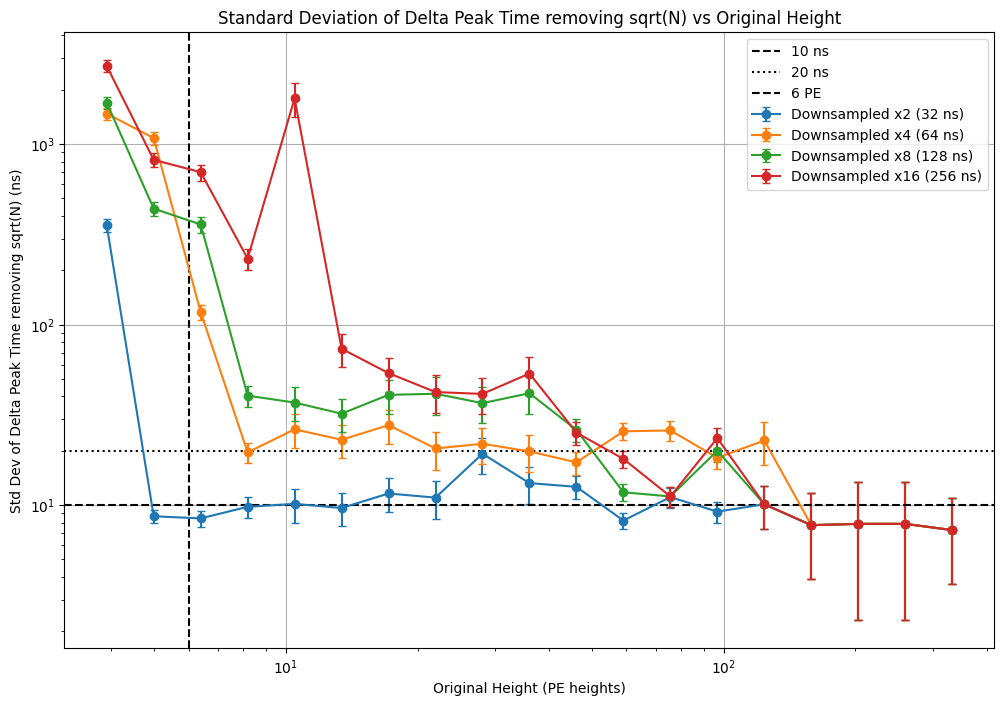

In [55]:
# calculate stddev_syst per bin using stddev_total = sqrt( sqrt(N)^2 + stddev_syst^2 )
N = np.histogram(hit_df_original['height'], bins=bins)[0]
sqrtN = np.sqrt(N)

def calc_stddev_syst(stddev_total, sqrtN):
  # Avoid division by zero or negative values under sqrt
  stddev_syst = np.sqrt(np.maximum(0, stddev_total**2 - sqrtN**2))
  return stddev_syst

std_2_syst = calc_stddev_syst(std_2, sqrtN)
std_4_syst = calc_stddev_syst(std_4, sqrtN)
std_8_syst = calc_stddev_syst(std_8, sqrtN)
std_16_syst = calc_stddev_syst(std_16, sqrtN)

bin_centers_npe = bin_centers*8.33

plt.figure(figsize=(12, 8))
plt.errorbar(bin_centers_npe, std_2_syst, yerr=std_2_syst/np.sqrt(N), fmt='o-', label='Downsampled x2 (32 ns)', capsize=3)
plt.errorbar(bin_centers_npe, std_4_syst, yerr=std_4_syst/np.sqrt(N), fmt='o-', label='Downsampled x4 (64 ns)', capsize=3)
plt.errorbar(bin_centers_npe, std_8_syst, yerr=std_8_syst/np.sqrt(N), fmt='o-', label='Downsampled x8 (128 ns)', capsize=3)
plt.errorbar(bin_centers_npe, std_16_syst, yerr=std_16_syst/np.sqrt(N), fmt='o-', label='Downsampled x16 (256 ns)', capsize=3)
plt.xlabel('Original Height (PE heights)')
plt.ylabel('Std Dev of Delta Peak Time removing sqrt(N) (ns)')
plt.title('Standard Deviation of Delta Peak Time removing sqrt(N) vs Original Height')
plt.xscale('log')
plt.yscale('log')
# add horizontal line at 10ns and 20ns
plt.axhline(y=10, color='k', linestyle='--', label='10 ns')
plt.axhline(y=20, color='k', linestyle=':', label='20 ns')
# add vertical line at 6PE
plt.axvline(x=6, color='k', linestyle='--', label='6 PE')
plt.legend()
plt.grid()
plt.show()